In [150]:
from datasets import load_dataset
import pandas as pd

raw_datasets = load_dataset(
    "json", 
    data_files={
        "train": "archive/train.json", 
        "validation": "archive/dev.json", 
        "test": "archive/test.json"
    }
)


On fait marcher le modèle de Greg

In [91]:
import sys
sys.path.append("graph")

from graph.predict import predict

In [98]:
probas = predict(list(raw_datasets["test"]), model_type="rgcn")
prob1numpy = probas[:, 1]

Using local data: C:\Users\octav\OneDrive\Bureau\hackathon\HackEurope-2026-Hoga\archive
Loading dataset splits...
  Loading train.json...
  Loading dev.json...
  Loading test.json...
  Labeled users: 11826 (train=8278, val=2365, test=1183)
  Total nodes: 191582 (11826 labeled, 179756 unlabeled neighbors)
Building edge index...
  Edges: 208716 (following=105701, follower=103015)
Extracting node features...
  Feature matrix: torch.Size([191582, 20])
  Labels: 5237 human, 6589 bot, 179756 unlabeled
  Masks: train=8278, val=2365, test=1183


In [137]:
prob1 = pd.DataFrame(prob1numpy, columns=["prob1"])
prob1.shape

(1183, 1)

On fait marcher le modèle d'Hadrien

In [110]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Hugging Face va automatiquement détecter et charger le fichier .safetensors
loaded_model = AutoModelForSequenceClassification.from_pretrained("mon_modele_safetensors")
loaded_tokenizer = AutoTokenizer.from_pretrained("mon_modele_safetensors")

In [188]:
from datasets import DatasetDict

def explode_tweets(examples):
    new_examples = {"ID": [], "text": [], "label": []}
    
    # On limite à 5 tweets par personne pour que ça aille très vite
    MAX_TWEETS_PER_USER = 5
    
    for user_id, tweets, label in zip(examples["ID"], examples["tweet"], examples["label"]):
        if not tweets: 
            continue
            
        if isinstance(tweets, str): 
            tweets = [tweets]
            
        tweets_to_keep = tweets[:MAX_TWEETS_PER_USER]
            
        for tweet in tweets_to_keep:
            if tweet: 
                new_examples["ID"].append(user_id)
                new_examples["text"].append(str(tweet))
                new_examples["label"].append(int(label) if label is not None else 0)
                
    return new_examples

# --- C'EST ICI QUE SE FAIT LA RÉDUCTION ---

# 1. On réduit la taille des jeux de données d'origine
small_train = raw_datasets["train"].select(range(4000))
small_valid = raw_datasets["validation"].select(range(500))
small_test = raw_datasets["test"].select(range(500)) # On réduit le test aussi pour que l'évaluation soit rapide

# 2. On les regroupe dans un DatasetDict (pour que la cellule de tokenisation fonctionne normalement)
small_raw_datasets = DatasetDict({
    "train": small_train,
    "validation": small_valid,
    "test": small_test
})

# 3. On applique notre fonction uniquement sur ce petit dataset
processed_datasets = raw_datasets.map(
    explode_tweets, 
    batched=True, 
    remove_columns=raw_datasets["train"].column_names
)

print(processed_datasets)

DatasetDict({
    train: Dataset({
        features: ['ID', 'label', 'text'],
        num_rows: 40426
    })
    validation: Dataset({
        features: ['ID', 'label', 'text'],
        num_rows: 11546
    })
    test: Dataset({
        features: ['ID', 'label', 'text'],
        num_rows: 5719
    })
})


In [173]:
print(processed_datasets.shape)
print(raw_datasets.shape)

{'train': (40426, 3), 'validation': (11546, 3), 'test': (5719, 3)}
{'train': (8278, 6), 'validation': (2365, 6), 'test': (1183, 6)}


In [174]:
from transformers import pipeline
import pandas as pd

# Pipeline
clf = pipeline("text-classification", model=loaded_model, tokenizer=loaded_tokenizer, device=0)

# Prédictions sur tout le test
test_texts = list(processed_datasets["test"]["text"])
predictions = clf(test_texts, batch_size=32, top_k=None)

# Vérifier les labels
print("Labels :", predictions[0])

# Extraire proba LABEL_1
probs = [
    next(p["score"] for p in pred if p["label"] == "LABEL_1")
    for pred in predictions
]

# Résultat
df_pred = pd.DataFrame({
    "ID": processed_datasets["test"]["ID"],
    "label": processed_datasets["test"]["label"],
    "prob_bot": probs
})

print(df_pred.head())

Device set to use cpu


Labels : [{'label': 'LABEL_0', 'score': 0.9386758208274841}, {'label': 'LABEL_1', 'score': 0.061324186623096466}]
                    ID  label  prob_bot
0  1188812492010487808      1  0.061324
1  1188812492010487808      1  0.253065
2  1188812492010487808      1  0.785901
3  1188812492010487808      1  0.801452
4  1188812492010487808      1  0.697267


In [175]:
# 3. Regrouper par ID utilisateur et faire le Vote Majoritaire
user_predictions = df_pred.groupby("ID").agg(
    # Le mode() prend la valeur la plus fréquente. [0] prend la première en cas d'égalité
    majority_pred=("prob_bot", lambda x: x.mode()[0]), 
    true_label=("label", "first") # Le vrai label est le même pour tous les tweets de l'ID
)

In [131]:
prob3 = df_pred[["prob_bot"]]
prob3 = prob3.rename(columns={"prob_bot": "prob3"})
prob3.head(5)

,prob3
0,0.061324
1,0.253065
2,0.785901
3,0.801452
4,0.697267


In [136]:
prob3=1-prob3
prob3.shape

(22425, 1)

On fait marcher le modèle de Aziz

In [76]:
import importlib
import aziz_code
importlib.reload(aziz_code)
from aziz_code import create_csv, create_features3, predict_bot_probability

In [77]:
import pickle
import pandas as pd
# ── Charger le modèle ─────────────────────────────────────────────────────────
with open('bot_detector.pkl', 'rb') as f:
    saved = pickle.load(f)
model    = saved['model']
features = saved['features']

In [105]:
df = create_csv(raw_datasets["test"])
print(df.shape)
df = create_features3(df)

results = predict_bot_probability(df, model,features)
prob2 = results[["prob_bot"]]

(1183, 20)


In [133]:
df_prob = pd.concat([prob1, prob2,prob3], axis=1)
df_prob = df_prob.rename(columns={"prob_bot": "prob2"})

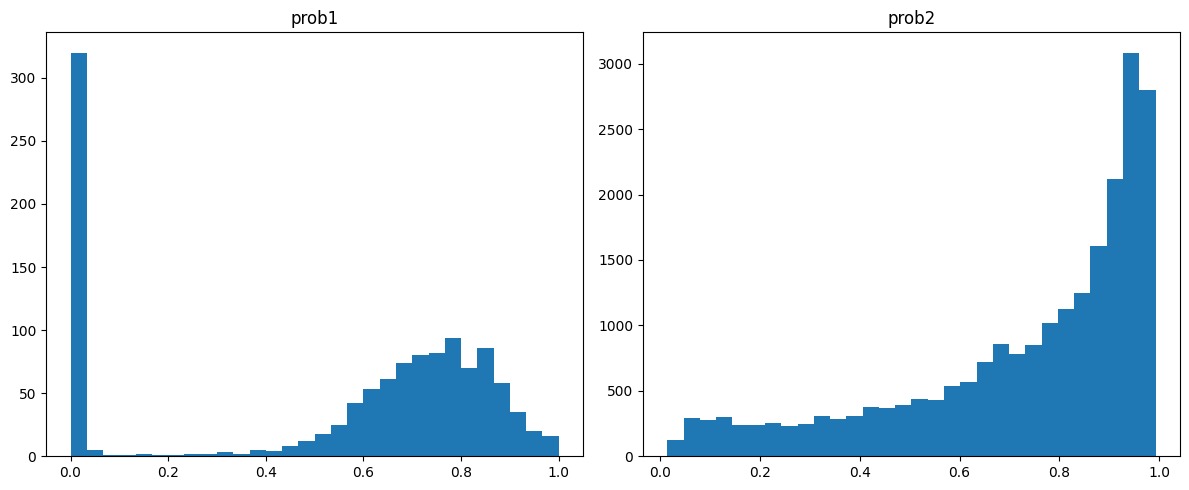

          prob1     prob2     prob3
prob1  1.000000  0.905755 -0.013795
prob2  0.905755  1.000000 -0.016544
prob3 -0.013795 -0.016544  1.000000


In [135]:
import matplotlib.pyplot as plt

# Histogrammes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(prob1, bins=30)
axes[0].set_title("prob1")
axes[1].hist(prob3, bins=30)
axes[1].set_title("prob2")
plt.tight_layout()
plt.show()

# Corrélation
print(df_prob.corr())

In [108]:
print(visu.columns.tolist())

['prob1', 'prob2']


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

on fait les trucs qui contiendront les différentes méthodes

On a df_prob qui a prob1, prob2, prob3 et label

In [ ]:
acc1 = accuracy_score(df_prob["label"], (df_prob["prob1"] >= 0.5).astype(int))
acc2 = accuracy_score(df_prob["label"], (df_prob["prob2"] >= 0.5).astype(int))
acc3 = accuracy_score(df_prob["label"], (df_prob["prob3"] >= 0.5).astype(int))

print(f"Acc modèle 1: {acc1:.4f}")
print(f"Acc modèle 2: {acc2:.4f}")
print(f"Acc modèle 3: {acc3:.4f}")

In [ ]:
df_resultprob = pd.DataFrame()
df_pred = pd.DataFrame()

In [ ]:
#Moyenne normale des probas
df_resultprob["avg"] = df_prob[["prob1", "prob2", "prob3"]].mean(axis=1)
df_pred["avg"] = (df_resultprob["avg"] >= 0.5).astype(int)
print(f"Acc avg: {accuracy_score(df_prob['label'], df_pred['avg']):.4f}")

In [ ]:
#Moyenne pondérée par les accuracy
total = acc1 + acc2 + acc3
df_resultprob["wavg"] = (acc1 * df_prob["prob1"] + acc2 * df_prob["prob2"] + acc3 * df_prob["prob3"]) / total
df_pred["wavg"] = (df_resultprob["wavg"] >= 0.5).astype(int)
print(f"Acc wavg: {accuracy_score(df_prob['label'], df_pred['wavg']):.4f}")

In [ ]:
# ElasticNet
from sklearn.linear_model import ElasticNet

lam = 0.01
l1_ratio = 0.5

enet = ElasticNet(alpha=lam, l1_ratio=l1_ratio)
enet.fit(df_prob[["prob1", "prob2", "prob3"]], df_prob["label"])
df_resultprob["enet"] = enet.predict(df_prob[["prob1", "prob2", "prob3"]]).clip(0, 1)
df_pred["enet"] = (df_resultprob["enet"] >= 0.5).astype(int)
print(f"Acc ElasticNet (lambda={lam}, l1_ratio={l1_ratio}): {accuracy_score(df_prob['label'], df_pred['enet']):.4f}")

In [ ]:
# Régression logistique
from sklearn.linear_model import LogisticRegression

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

df_resultprob["logreg"] = np.nan
for train_idx, val_idx in kf.split(df_prob):
    logreg = LogisticRegression()
    logreg.fit(df_prob.loc[train_idx, ["prob1", "prob2", "prob3"]], df_prob.loc[train_idx, "label"])
    df_resultprob.loc[val_idx, "logreg"] = logreg.predict_proba(df_prob.loc[val_idx, ["prob1", "prob2", "prob3"]])[:, 1]

df_pred["logreg"] = (df_resultprob["logreg"] >= 0.5).astype(int)
print(f"Acc LogReg (KFold): {accuracy_score(df_prob['label'], df_pred['logreg']):.4f}")

In [ ]:
# LightGBM
import lightgbm as lgb

df_resultprob["lgbm"] = np.nan
for train_idx, val_idx in kf.split(df_prob):
    lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, verbose=-1)
    lgb_model.fit(df_prob.loc[train_idx, ["prob1", "prob2", "prob3"]], df_prob.loc[train_idx, "label"])
    df_resultprob.loc[val_idx, "lgbm"] = lgb_model.predict_proba(df_prob.loc[val_idx, ["prob1", "prob2", "prob3"]])[:, 1]

df_pred["lgbm"] = (df_resultprob["lgbm"] >= 0.5).astype(int)
print(f"Acc LightGBM (KFold): {accuracy_score(df_prob['label'], df_pred['lgbm']):.4f}")